***
# Clustering
MSDS 7331-407, Lab 3 
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

## Table of Contents

<a href='#Section_1'> 1. Business Understanding 1 </a>  
<a href='#Section_2'> 2. Preparation and Dataset Loading </a>  
<a href='#Section_3'> 3. Data Understanding 1</a>  
<a href='#Section_4'> 4. Data Understanding 2 </a>  
<a href='#Section_5'> 5. Modeling and Evaluation 1 </a>  
<a href='#Section_6'> 6. Modeling and Evaluation 2 </a>  
<a href='#Section_7'> 7. Modeling and Evaluation 3 </a>  
<a href='#Section_8'> 8. Modeling and Evaluation 4 </a>  
<a href='#Section_9'> 9. Deployment </a>  
<a href='#Section_10'> 10. Exceptional Work </a>  

<a id = 'Section_1'></a>

## 1. Business Understanding

*(10 points)*

*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

<a id = 'Section_2'></a>

## 2. Preparation and Dataset Loading

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
import seaborn as sn
import seaborn as sns
import pylab as plt
import plotly.graph_objs as go

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Models and Metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from kmodes.kmodes import KModes
from sklearn import datasets
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import AgglomerativeClustering

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [3]:
DATA_SOURCE="./diabetic_data.csv"

df_raw = pd.read_csv(DATA_SOURCE)

df = df_raw
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 101,766 rows and 50 columns


<a id = 'Section_3'></a>

## 3. Data Understanding 1

(10 points) 

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

| Feature Name | Type | Description and Values |
|:---|:---|:---|
| encounter_id | Numeric | Unique identifier of an encounter |
| patient_nbr | Numeric | Unique identifier of a patient |
| race | Nominal | Values: Caucasian, Asian, African American, Hispanic, and other |
| gender | Nominal | Values: male, female, and unknown/invalid |
| age | Nominal | Grouped in 10-year intervals: 0-10, 10-20, ..., 90-100 |
| weight | Numeric | Weight in pounds |
| admission_type_id | Nominal | Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available |
| discharge_disposition_id | Nominal | Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available |
| admission_source_id | Nominal | Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital |
| time_in_hospital | Numeric | Integer number of days between admission and discharge |
| payer_code | Nominal | Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay |
|medical_specialty | Nominal | Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon |
| num_lab_procedures | Numeric | Number of lab tests performed during the encounter |
| num_procedures | Numeric | Number of procedures (other than lab tests) performed during the encounter |
| num_medications | Numeric | Number of distinct generic names administered during the encounter |
| number_outpatient | Numeric | Number of outpatient visits of the patient in the year preceding the encounter |
| number_emergency | Numeric | Number of emergency visits of the patient in the year preceding the encounter |
| number_inpatient | Numeric | Number of inpatient visits of the patient in the year preceding the encounter |
| diag_1 | Nominal | The primary diagnosis (coded as first three digits of ICD9); 848 distinct values |
| diag_2 | Nominal | Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values |
| diag_3 | Nominal | Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values |
| number_diagnoses | Numeric | Number of diagnoses entered to the system |
| max_glu_serum | Nominal | Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured |
| A1Cresult | Nominal | Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured |
| change | Nominal | Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change” |
| diabetesMed | Nominal | Indicates if there was any diabetic medication prescribed. Values: “yes” and “no” |
| 24 features for medications | Nominal | For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed |
| readmitted | Nominal | Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission. |

NEED A FORMAT FOR THIS CITATION

Source: TY - JOUR
TI - Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records
VL - 2014
PY - 2014
DA - 2014/04/03
DO - 10.1155/2014/781670
UR - https://doi.org/10.1155/2014/781670
JF - BioMed Research International
SN - 2314-6133
PB - Hindawi Publishing Corporation
SP - 781670
A2 - Rizvi, Ali
AU - Strack, Beata
AU - DeShazo, Jonathan P.
AU - Gennings, Chris
AU - Olmo, Juan L.
AU - Ventura, Sebastian
AU - Cios, Krzysztof J.
AU - Clore, John N.

|Admission Type ID| Description | 
|:---|:---|
|1| Emergency | 
|2| Urgent | 
|3| Elective |
|4| Newborn |
|5| Not Available | 
|6| NULL |
|7| Trauma Center |
|8| Not Mapped | 

|Discharge Disposition|Description|
|:---|:---|
|1| discharged to home|
|2| discharged/transferred to short term hospital|
|3| discharged/transferred to SNF (skilled nursing facility)|
|4| discharged/transferred to ICF (intermediate care facility)|
|5| discharged/transferred to another type of inpatient care institution|
|6| discharged/transferred to home with home health service|
|7| left AMA (against medical advice)|
|8| discharged/transferred to home under care of Home IV provider (intravenous care/therapy)|
|9| admitted as inpatient to receiving hospital |
|10| neonate discharged to another hospital for neonatal aftercare|
|12| expired|
|13| still patient/expected to return for outpatient services|
|14| hospice/home|
|15| hospice/medical facility|
|16| discharged/transferred within institution to medicare approved swing bed|
|17| discharged/transferred/referred another institution for outpatient services|
|18| NULL |
|19| expired at home, medicaid only, hospice|
|20|  expired in a medical facility, medicate only, hospice|
|21| expired, place unknown, medicaid only, hospice|
|22| discharged/transferred to another rehab facility including rehab units of a hospital|
|23| discharged/transferred to a long term care facility |
|24| discharged/transferred to a nursing facility certified under medicaid but not medicare |
|25| not mapped |
|26| discharged/transferred to an undefined health care facility|
|27| discharged/transferred to a federal health care facility|
|28| discharged/transferred/referred to a psychiatric hospital or psychiatric unit of hospital |
|29| discharged/transferred to CAH (critical access hospital) |

| Admission Source ID | Description |
|:---|:---|
|1| physician referral |
|2| clinic referral|
|3| HMO referral|
|4| transfer from a hospital|
|5| transfer from SNF (skilled nursing facility) |
|6| transfer from another health care facility |
|7| ER |
|8| court/law enforcement |
|9| not available |
|10| transfer from CAH (critical access hospital) |
|11| normal delivery |
|12| premature delivery |
|13| sick baby |
|14| extramural birth |
|15| not available |
|16| NULL transfer | 
|17| from another home health agency |
|18| readmission to same home health agency |
|19|  not mapped |
|20| unknown/invalid |
|21| transfer from hostpital inpatient/same facility resulting in separate claim |
|22| born inside this hospital |
|23| born outside this hospital |
|24| transfer from ambulatory surgery center|
|25| transfer from hospice |

### Duplicated Data

In [4]:
df.duplicated().sum()

0

In [5]:
#HOW MANY PATIENTS APPEAR IN THE DATASET MORE THAN ONCE?
df['patient_nbr'].duplicated().sum()

30248

### Drop Columns that will not be Used

In [6]:
#drop columns that aren't relevant or we aren't going to use
#we can use number_diagnoses in place of diag_1, diag_2, diag_3
df.drop(['encounter_id','patient_nbr','diag_1','diag_2','diag_3'], axis=1, inplace=True)

#for now drop the medication columns to shrink the dataset
df.drop(['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], axis=1, inplace=True)

### Missing Data

In [7]:
df = df.replace('?', np.nan)
df = df.replace('None', np.nan)

In [8]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,1,0,0,0,1,NaN,NaN,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,18,0,0,0,9,NaN,NaN,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,13,2,0,1,6,NaN,NaN,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,16,0,0,0,7,NaN,NaN,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,8,0,0,0,5,NaN,NaN,Ch,Yes,NO


In [9]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Missing Values', '% of Total  Values'])

Need to drop weight, since 96.86% of the values are missing.
Drop rows where payer_code is missing, still leaves us with enough data.
Need to drop medical_specialty because not enough records are left after dropping rows where payer_code is missing.

In [10]:
missing_data(df)

,Missing Values,% of Total Values
weight,98569,96.858479
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
gender,0,0.000000
age,0,0.000000
admission_type_id,0,0.000000
discharge_disposition_id,0,0.000000


In [11]:
df.drop(['weight','medical_specialty','max_glu_serum','A1Cresult'], axis=1, inplace=True)

In [12]:
df.dropna(subset=['payer_code','race'], axis=0, inplace=True)

In [13]:
missing_data(df)

,Missing Values,% of Total Values
readmitted,0,0.0
diabetesMed,0,0.0
gender,0,0.0
age,0,0.0
admission_type_id,0,0.0
discharge_disposition_id,0,0.0
admission_source_id,0,0.0
time_in_hospital,0,0.0
payer_code,0,0.0
num_lab_procedures,0,0.0


### Prepare Dataset for Clustering

In [14]:
#target variable
target = {"readmitted": {"NO": 0, "<30": 1, ">30": 2}}
df.replace(target,inplace=True)

In [15]:
#create a function to count by column and display percentages
def count_percent(data,field):
    df_grouped = data.groupby(by=field)
    c1 = (df_grouped[field].count())

    c2  = []#create empty list to store percentages
    for x in c1:
        c2.append("{:.2%}".format((x/sum(c1)))) #row value divided by total, formatted as percent, store in list
    c1 = pd.DataFrame(c1) #needs dataframe to start with, then can add new column from list c2
    c1['Percent']= c2
    c1.columns = ['Count','Percent']
    return c1

In [16]:
count_percent(df,'age')

,Count,Percent
age,,
[0-10),13,0.02%
[10-20),220,0.37%
[20-30),1006,1.68%
[30-40),2045,3.42%
[40-50),5376,8.99%
[50-60),9696,16.22%
[60-70),13219,22.11%
[70-80),15080,25.23%
[80-90),11186,18.71%


In [17]:
df['age_num'] = df['age'].astype(str).str[1]
df.drop(['age'], axis=1, inplace=True)

In [18]:
#onehot encoding for variables with 2 categories
#this dataset to be used with K-MODES
df['IsMale'] = df.gender=='Male' 
df.IsMale = df.IsMale.astype(np.int)
df.drop(['gender'], axis=1, inplace=True)

df['med_change'] = df.change=='Ch'
df.med_change = df.med_change.astype(np.int)
df.drop(['change'], axis=1, inplace=True)

df['med_diabetes'] = df.diabetesMed=='Yes'
df.med_diabetes = df.med_diabetes.astype(np.int)
df.drop(['diabetesMed'], axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59781 entries, 20446 to 101764
Data columns (total 18 columns):
race                        59781 non-null object
admission_type_id           59781 non-null int64
discharge_disposition_id    59781 non-null int64
admission_source_id         59781 non-null int64
time_in_hospital            59781 non-null int64
payer_code                  59781 non-null object
num_lab_procedures          59781 non-null int64
num_procedures              59781 non-null int64
num_medications             59781 non-null int64
number_outpatient           59781 non-null int64
number_emergency            59781 non-null int64
number_inpatient            59781 non-null int64
number_diagnoses            59781 non-null int64
readmitted                  59781 non-null int64
age_num                     59781 non-null object
IsMale                      59781 non-null int32
med_change                  59781 non-null int32
med_diabetes                59781 non-null int32
d

In [20]:
df.head()

,race,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,age_num,IsMale,med_change,med_diabetes
20446,Caucasian,1,22,7,7,MC,58,2,15,0,0,0,9,0,7,0,1,1
20737,Caucasian,2,1,1,3,MC,59,3,11,0,0,0,6,0,6,0,0,1
20824,Caucasian,1,1,7,4,MC,56,1,9,0,0,0,6,0,9,0,0,1
21083,Caucasian,1,2,7,10,MC,68,1,18,0,0,0,6,0,7,1,1,1
23668,Caucasian,2,1,1,4,MC,33,0,11,0,0,0,4,1,6,0,1,1


In [21]:
#create new dataset to be used with distance based clustering algorithms
df_imputed = df

In [22]:
#onehot encoding for variables with more than 2 categories
tmp_df = pd.get_dummies(df_imputed.race,prefix='race')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['race'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.payer_code,prefix='payer')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['payer_code'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_type_id,prefix='admission_type')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_type_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.discharge_disposition_id,prefix='discharge')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['discharge_disposition_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_source_id,prefix='admission_source')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_source_id'], axis=1, inplace=True)

In [23]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59781 entries, 20446 to 101764
Data columns (total 81 columns):
time_in_hospital        59781 non-null int64
num_lab_procedures      59781 non-null int64
num_procedures          59781 non-null int64
num_medications         59781 non-null int64
number_outpatient       59781 non-null int64
number_emergency        59781 non-null int64
number_inpatient        59781 non-null int64
number_diagnoses        59781 non-null int64
readmitted              59781 non-null int64
age_num                 59781 non-null object
IsMale                  59781 non-null int32
med_change              59781 non-null int32
med_diabetes            59781 non-null int32
race_AfricanAmerican    59781 non-null uint8
race_Asian              59781 non-null uint8
race_Caucasian          59781 non-null uint8
race_Hispanic           59781 non-null uint8
race_Other              59781 non-null uint8
payer_BC                59781 non-null uint8
payer_CH                59781 

In [24]:
df.head(10)

,race,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,age_num,IsMale,med_change,med_diabetes
20446,Caucasian,1,22,7,7,MC,58,2,15,0,0,0,9,0,7,0,1,1
20737,Caucasian,2,1,1,3,MC,59,3,11,0,0,0,6,0,6,0,0,1
20824,Caucasian,1,1,7,4,MC,56,1,9,0,0,0,6,0,9,0,0,1
21083,Caucasian,1,2,7,10,MC,68,1,18,0,0,0,6,0,7,1,1,1
23668,Caucasian,2,1,1,4,MC,33,0,11,0,0,0,4,1,6,0,1,1
23701,Caucasian,1,6,7,8,MD,71,0,17,0,0,0,8,0,5,0,1,1
23871,Caucasian,1,1,1,1,HM,38,0,2,0,0,0,5,2,4,1,0,1
23879,Caucasian,1,3,6,12,UN,77,5,19,0,0,0,5,0,7,0,0,1
23922,Caucasian,1,3,6,12,MC,60,5,10,0,0,0,5,0,7,1,0,0
23927,AfricanAmerican,1,3,7,7,MC,52,1,7,0,0,0,7,0,8,1,0,1


In [25]:
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 59,781 rows and 18 columns


<a id = 'Section_4'></a>

## 4. Data Understanding 2

*(10 points)*

*Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

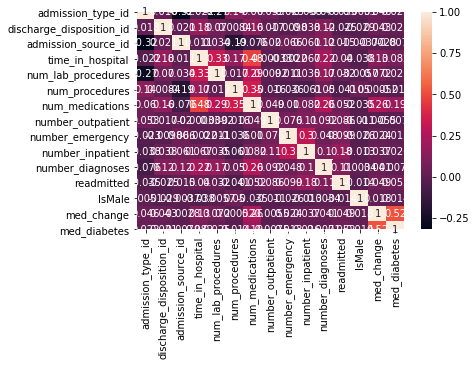

In [26]:
correlation1 = df.corr()
sn.heatmap(correlation1, annot = True)

correlation values
patient number and encounter id - .51 correlation, not useful, only tells us that patient numbers and encounters were generated side by side frequently

number of medications and time in hospital - .47, makes sense, longer hospital stay would result in more medication 

num_medications and number of procedures - .39, same logic

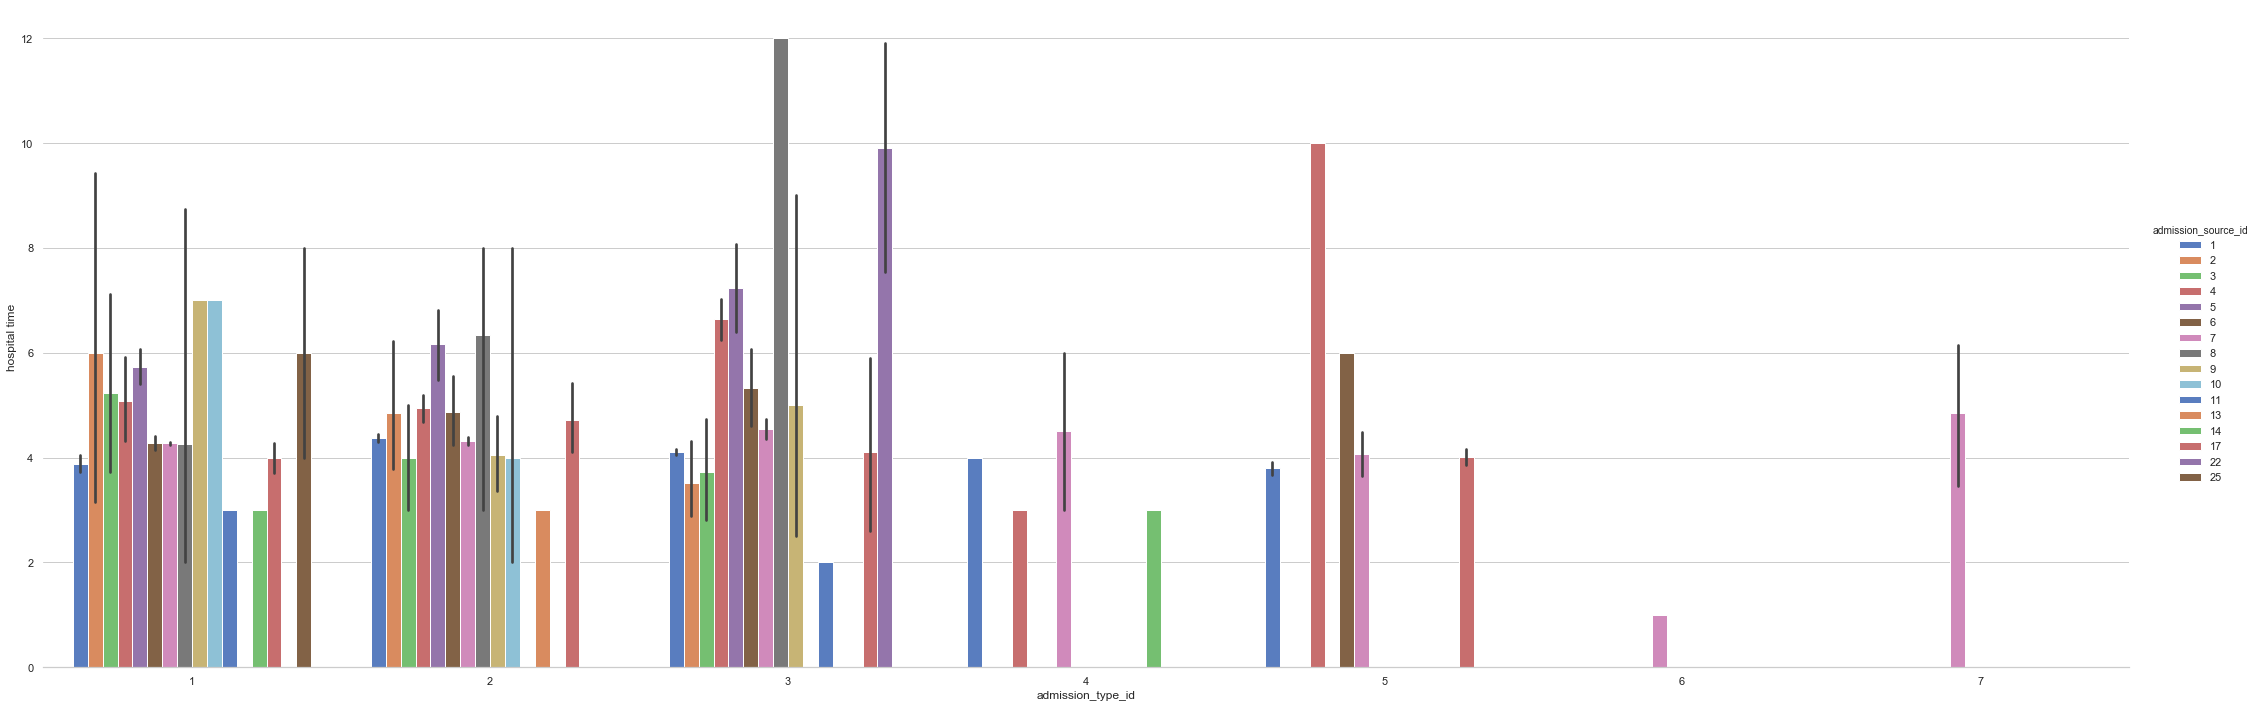

In [27]:
sns.set(style="whitegrid")

v1 = sns.catplot(x="admission_type_id", y="time_in_hospital", hue="admission_source_id", data=df,
                height=10, aspect = 3, kind="bar", palette="muted")
v1.despine(left=True)
v1.set_ylabels("hospital time")

Admission type 1 = Emergency admission has the most datapoints, wide variety of admission sources, largest admission category is "not available", with a hospital stay of 7 days (no whisker? indicating no stays in the category over 7 days?), perhaps indicating a wide variety of miscellaneous sources that dont fall into other categories. Patients with emergency admission from a CAH(critical admission hospital) and from a hospice have outliers that are the longest stays. 

Admission type 2 = Urgent's largest category of admissions is from court/law enforcement, but not by much. 

Admission type 3 = Elective type hospital admissions had a larger plurality sourced from courts/law enforcement, followed by SNF transfers (skilled nursing facility).

Admission type 4 = Newborn, understandably far fewer sources for newborns, only from sources 1, 4, 7, 14; physician, hospital transfer, ER, and extramural birth, respectively. Average stays for this admission type are noticably lower than other admission types. 

Admission type 5 = Not available, difficult to draw conclusions here, only used for sources 1, 4, 6, 7, 17; physician recommendation, hospital transfer, from another healthcare facility, ER, from another home health agency\

Admission type 6 = NULL, ???

Admission type 7 = Trauma Center, exclusively transfers from ER, average stay of 5 days. 

Admission type 8 = Not mapped, ??? 

<Figure size 1152x504 with 0 Axes>

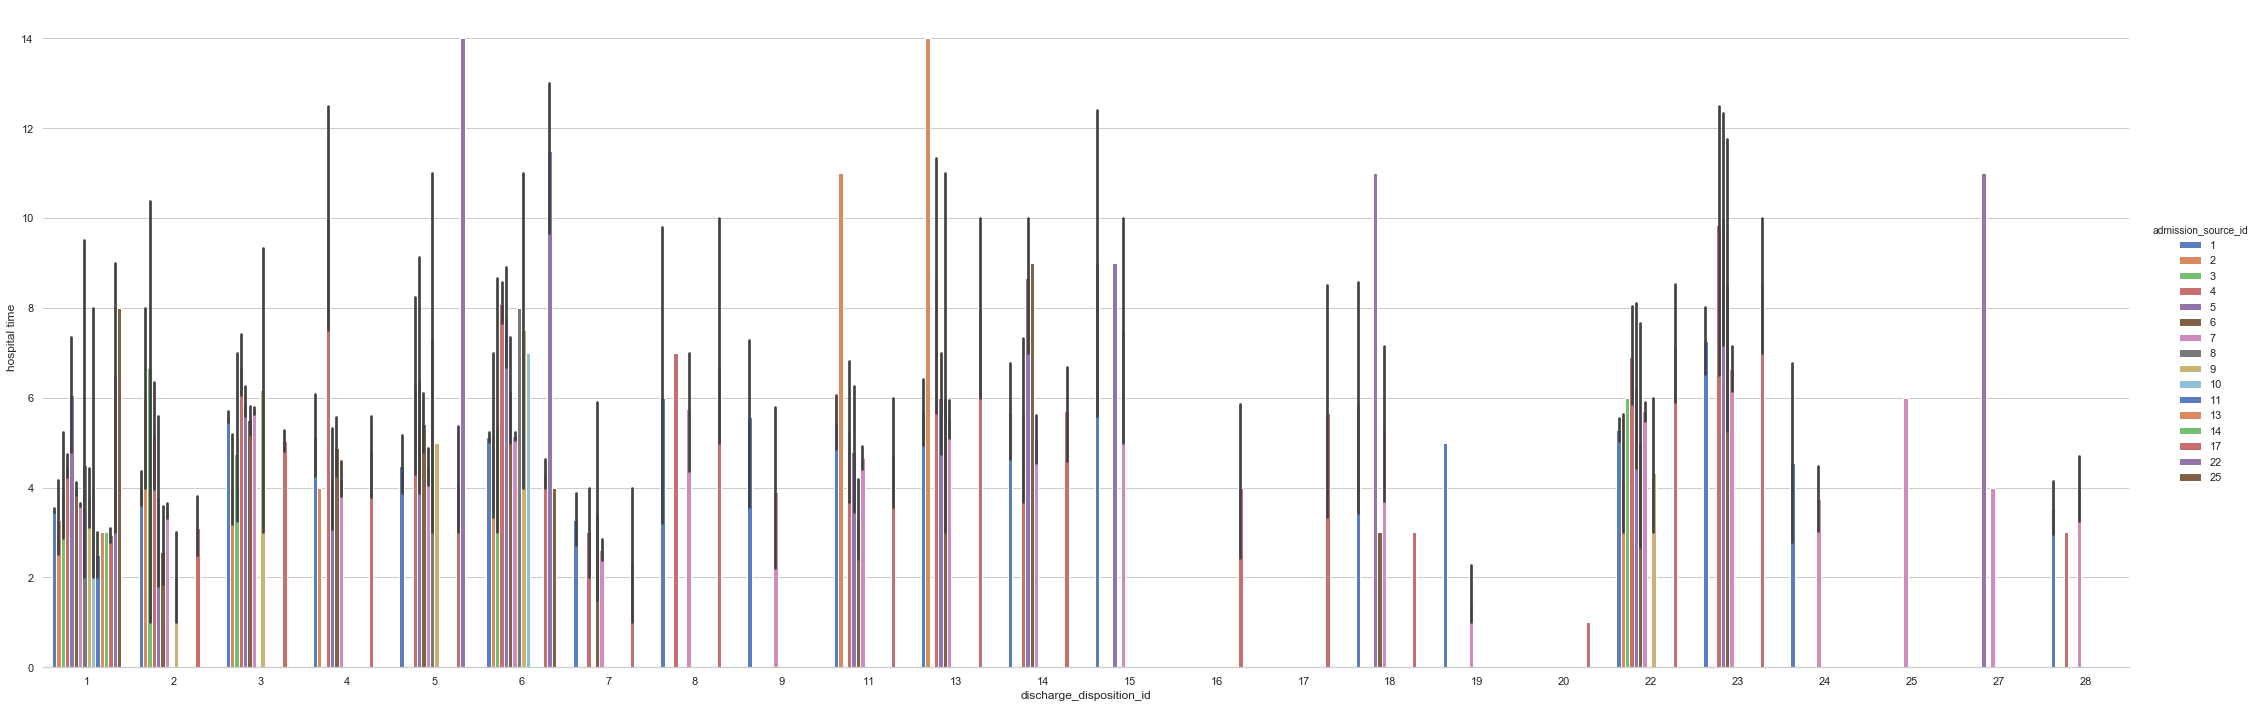

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize = (16, 7)) 
v2 = sns.catplot(x="discharge_disposition_id", y="time_in_hospital", hue="admission_source_id", data=df,
                height=10, aspect = 3, kind="bar", palette="muted")
v2.despine(left=True)
v2.set_ylabels("hospital time")

(this might be too much data to easily analyze, maybe split by discharge disposition?)

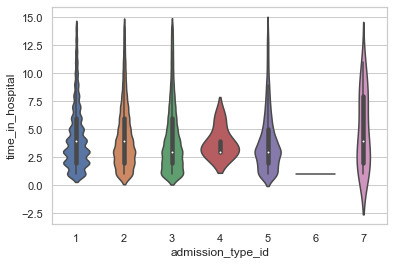

In [29]:
sns.violinplot(x="admission_type_id",y="time_in_hospital",data=df)

most skew around 2.5 days? admission type 7, trauma center, somehow has negative hospital stay duration???

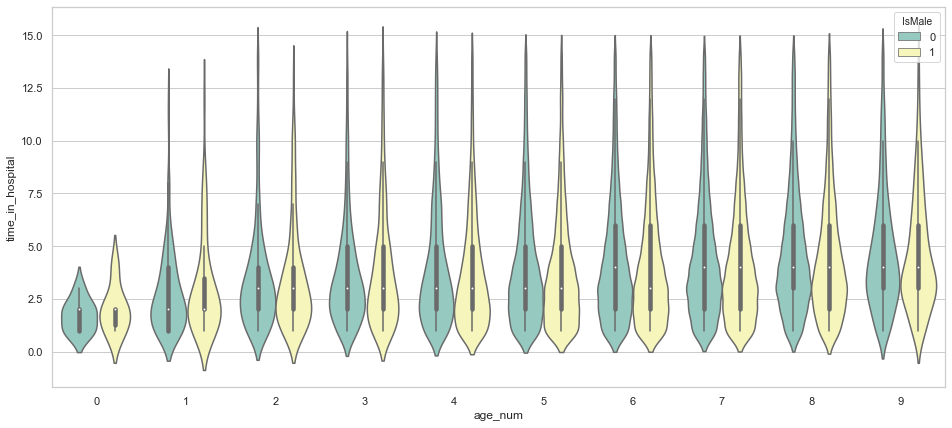

In [30]:
plt.figure(figsize = (16, 7)) 
sns.violinplot(x="age_num",y="time_in_hospital",hue='IsMale',data=df, palette="Set3")

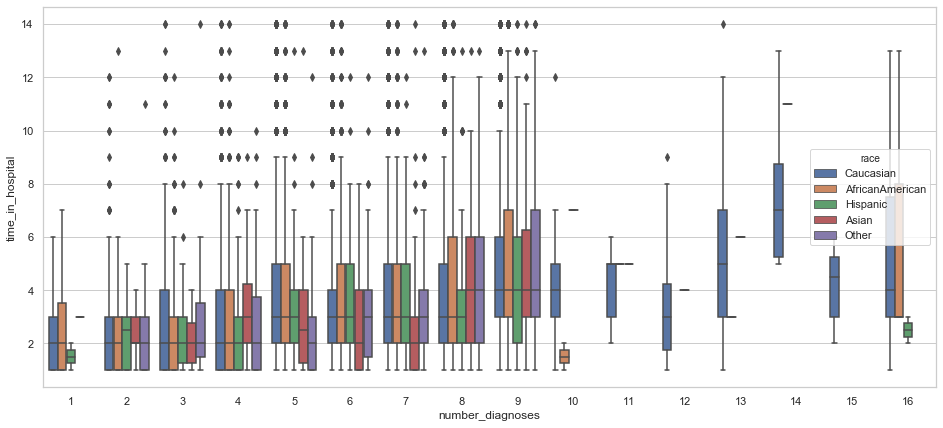

In [31]:
plt.figure(figsize = (16, 7))           
v4 =sns.boxplot(x = "number_diagnoses", y = "time_in_hospital", hue = 'race', data = df)

In [ ]:
import plotly.graph_objs as go
MAX_PLOTS_PER_GRAPH = 6
all_columns = list(df)
layout = go.Layout(title='Global Font',
                   font=dict(family='Courier New, monospace', size=8))

for i in range(0, len(all_columns), MAX_PLOTS_PER_GRAPH):
    dim = []
    columns = all_columns[i:i+MAX_PLOTS_PER_GRAPH]
    for column in columns:
        dim.append(dict(label = column, values = df[column]))

    fig = go.Figure(data=go.Splom(dimensions=dim, diagonal=dict(visible=False), marker=dict(color=df['readmitted'],
                              size=5,
                              line=dict(width=0.5,
                                        color='rgb(230,230,230)') )),
                    layout=layout)

    title = "Scatterplot Matrix for Diabetes Dataset"
    fig.update_layout(title=title,
                      dragmode='select',
                      width=1000,
                      height=1000,
                      hovermode='closest')

    fig.show()

<a id = 'Section_5'></a>

## 5. Modeling and Evaluation 1
*(10 points)*
	
*Train and adjust parameters. How did you determine a suitable number of clusters for each method?*

In [33]:
%%time
df_cluster = df_imputed.copy()

y = df_cluster['readmitted'].values
del df_cluster['readmitted']
X = df_cluster.values

scl = StandardScaler()
X = scl.fit_transform(X)

yhat = np.zeros(y.shape)
yhat_score = np.zeros((y.shape[0],3))

cv = StratifiedKFold(n_splits=10, random_state=1)

#clf = RandomForestClassifier(n_estimators=150,random_state=1)
clf = lgb.LGBMClassifier(n_estimators=150,random_state=1)

for train, test in cv.split(X,y):
    clf_fit = clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    yhat_score[test] = clf.predict_proba(X[test])

lb=LabelBinarizer()
lb.fit(y)
y_lb = lb.transform(y)
yhat_lb = lb.transform(yhat)
print ('AUC Score Micro', roc_auc_score(y_lb, yhat_score, average='micro', multi_class='ovr'))

AUC Score Micro 0.7727171557123935
Wall time: 59.6 s


In [48]:
def lgb_model(data,y):
    for train, test in cv.split(data,y):
        clf_fit = clf.fit(data[train],y[train])
        yhat[test] = clf.predict(data[test])
        yhat_score[test] = clf.predict_proba(data[test])

    lb=LabelBinarizer()
    lb.fit(y)
    y_lb = lb.transform(y)
    yhat_lb = lb.transform(yhat)
        
def cluster_metrics(y_lb, yhat_score, data, newfeature):
    print ("Clusters",i,"AUC Score Micro=", roc_auc_score(y_lb, yhat_score, average='micro', multi_class='ovr'))

    silhouette_e = metrics.silhouette_score(data, newfeature, metric='euclidean')
    silhouette_c = metrics.silhouette_score(data, newfeature, metric='cosine')
    seuclid.append(silhouette_e)
    scosine.append(silhouette_c)

    print("Homogeneity: ", metrics.homogeneity_score(y, newfeature))
    print("Completeness: ", metrics.completeness_score(y, newfeature))
    print("V-measure: ", metrics.v_measure_score(y, newfeature))
    print("Adjusted Rand Index: ", metrics.adjusted_rand_score(y, newfeature))
    print("Adjusted Mutual Information: ", metrics.adjusted_mutual_info_score(y, newfeature, average_method='arithmetic'))
    print("Silhouette Coefficient - Euclidean: ", silhouette_e)
    print("Silhouette Coefficient - Cosine: ", silhouette_c)
        
def silhouette_plot(k,seuclid,scosine):
    plt.figure(figsize=(10,5))
    plt.plot(k,seuclid,label='euclidean')
    plt.plot(k,scosine,label='cosine')
    plt.ylabel("Silhouette")
    plt.xlabel("Cluster")
    plt.title("Silhouette vs Cluster Size")
    plt.legend()
    plt.show()

Clusters 5 AUC Score Micro= 0.7666059773319458
Homogeneity:  0.008659675535042263
Completeness:  0.006349819546786527
V-measure:  0.007327012225455975
Adjusted Rand Index:  0.013093249017207998
Adjusted Mutual Information:  0.007267515953431243
Silhouette Coefficient - Euclidean:  0.4309310844170552
Silhouette Coefficient - Cosine:  0.004541500144291392
Clusters 6 AUC Score Micro= 0.7691300525093046
Homogeneity:  0.01765810824216597
Completeness:  0.011824329070907524
V-measure:  0.01416404487918562
Adjusted Rand Index:  0.009667627814149435
Adjusted Mutual Information:  0.01409408462479374
Silhouette Coefficient - Euclidean:  0.4375551895522113
Silhouette Coefficient - Cosine:  -0.14304852167275434
Clusters 7 AUC Score Micro= 0.7700542868289484
Homogeneity:  0.015972938994806642
Completeness:  0.009766754747785832
V-measure:  0.01212164987848909
Adjusted Rand Index:  0.005482323787392321
Adjusted Mutual Information:  0.01204203161732311
Silhouette Coefficient - Euclidean:  0.528818185

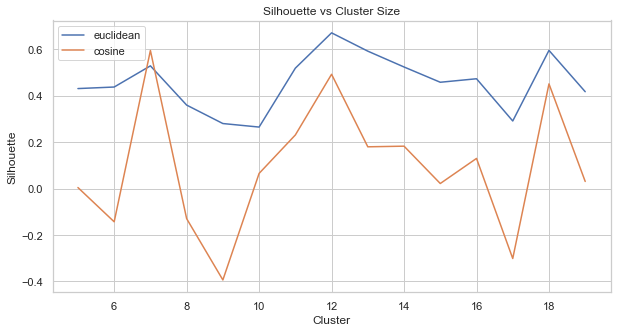

Wall time: 59min 57s


In [39]:
%%time
X1 = df[['admission_source_id','discharge_disposition_id']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6','discharge_7',
               'discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15','discharge_16',
               'discharge_17','discharge_18','discharge_19','discharge_20','discharge_22','discharge_23','discharge_24',
               'discharge_25','discharge_27','discharge_28'], axis=1, inplace=True)
X = df_kmodes.values

scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7723331924794767
Homogeneity:  0.004619400661885111
Completeness:  0.003636707579448766
V-measure:  0.004069571015428953
Adjusted Rand Index:  -0.00982461159530787
Adjusted Mutual Information:  0.0040074800322188586
Silhouette Coefficient - Euclidean:  0.8127773505013275
Silhouette Coefficient - Cosine:  0.7729673785547396
Clusters 6 AUC Score Micro= 0.7752335080884117
Homogeneity:  0.005890122470435238
Completeness:  0.004963798218886645
V-measure:  0.005387431927070271
Adjusted Rand Index:  -0.001988038862705702
Adjusted Mutual Information:  0.005306864931025592
Silhouette Coefficient - Euclidean:  0.6191729431960252
Silhouette Coefficient - Cosine:  0.4980895517348209
Clusters 7 AUC Score Micro= 0.7732067373022151
Homogeneity:  0.008125232947625181
Completeness:  0.006043651733360355
V-measure:  0.0069315375618479455
Adjusted Rand Index:  -0.008618436580011476
Adjusted Mutual Information:  0.0068415589469925904
Silhouette Coefficient - Euclidean:  0.845

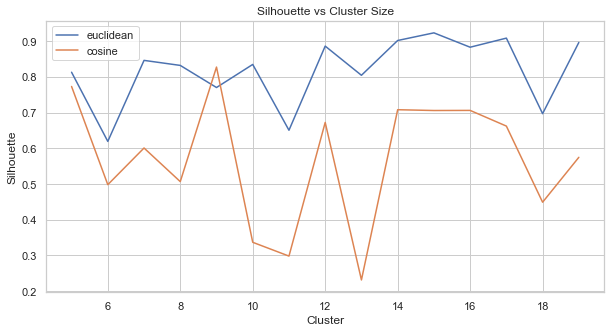

Wall time: 1h 4min 37s


In [40]:
%%time
X1 = df[['admission_source_id','race']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7636677058452146
Homogeneity:  0.004904057177943592
Completeness:  0.003515014800840779
V-measure:  0.004094948613832888
Adjusted Rand Index:  0.011923314954187839
Adjusted Mutual Information:  0.0040361033362918824
Silhouette Coefficient - Euclidean:  0.32795946038708945
Silhouette Coefficient - Cosine:  0.21131741266828205
Clusters 6 AUC Score Micro= 0.766141872634019
Homogeneity:  0.006704908264590163
Completeness:  0.004219500860652912
V-measure:  0.005179477602621828
Adjusted Rand Index:  0.01031840803957022
Adjusted Mutual Information:  0.005111491746102561
Silhouette Coefficient - Euclidean:  0.40187342076139615
Silhouette Coefficient - Cosine:  0.36047920348337387
Clusters 7 AUC Score Micro= 0.7651757398191079
Homogeneity:  0.005720534585466052
Completeness:  0.0032656096074999332
V-measure:  0.004157741585530398
Adjusted Rand Index:  0.007224075235686005
Adjusted Mutual Information:  0.004080291845088312
Silhouette Coefficient - Euclidean:  0.3111

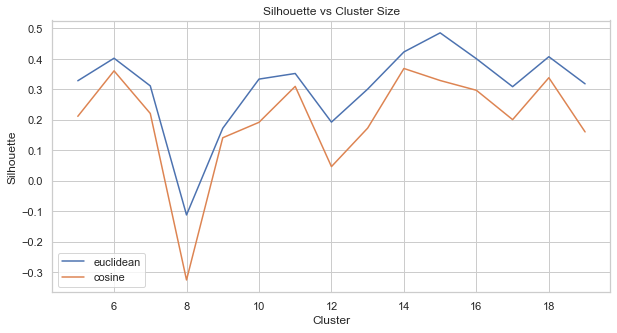

Wall time: 56min 41s


In [41]:
%%time
X1 = df[['admission_source_id','discharge_disposition_id','admission_type_id']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6','discharge_7',
               'discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15','discharge_16',
               'discharge_17','discharge_18','discharge_19','discharge_20','discharge_22','discharge_23','discharge_24',
               'discharge_25','discharge_27','discharge_28',
               'admission_type_1','admission_type_2','admission_type_3','admission_type_4','admission_type_5',
               'admission_type_6','admission_type_7'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.77256637367901
Homogeneity:  0.0013214863508954728
Completeness:  0.0009223970116020188
V-measure:  0.001086451355993958
Adjusted Rand Index:  -0.0027270410067541644
Adjusted Mutual Information:  0.0010283397541512153
Silhouette Coefficient - Euclidean:  -0.11754386330973349
Silhouette Coefficient - Cosine:  -0.5210858332036123
Clusters 6 AUC Score Micro= 0.7725797852940123
Homogeneity:  0.002170891185408113
Completeness:  0.0013705878023003231
V-measure:  0.001680313218950889
Adjusted Rand Index:  -0.00441506938027137
Adjusted Mutual Information:  0.0016119627578036202
Silhouette Coefficient - Euclidean:  -0.03872515884651907
Silhouette Coefficient - Cosine:  0.19271384403610162
Clusters 7 AUC Score Micro= 0.7728971486517839
Homogeneity:  0.0023620977614669325
Completeness:  0.0013367900415989793
V-measure:  0.0017073395749906013
Adjusted Rand Index:  -0.004710995807442723
Adjusted Mutual Information:  0.001630746520730794
Silhouette Coefficient - Euclide

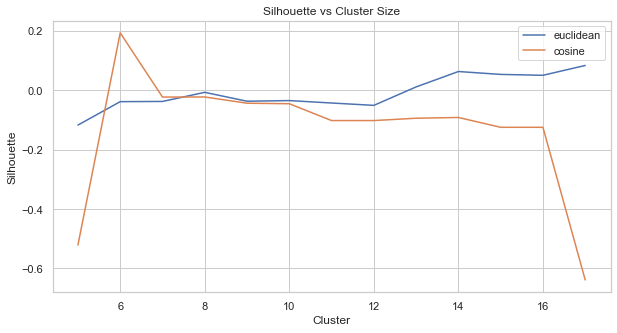

Wall time: 56min 20s


In [42]:
%%time
X1 = df[['payer_code','num_procedures']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
                'payer_WC','num_procedures'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,18)
for i in k:
    
    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7724993010535302
Homogeneity:  0.0028656355798864644
Completeness:  0.002387580182411711
V-measure:  0.002604855779827176
Adjusted Rand Index:  -0.005379613999818833
Adjusted Mutual Information:  0.00254069369582187
Silhouette Coefficient - Euclidean:  0.3838955659701799
Silhouette Coefficient - Cosine:  -0.03862021598659089
Clusters 6 AUC Score Micro= 0.7727357530306093
Homogeneity:  0.007206951040108488
Completeness:  0.00448099155349566
V-measure:  0.005526085789445084
Adjusted Rand Index:  -0.0016576853279339152
Adjusted Mutual Information:  0.005458627883243053
Silhouette Coefficient - Euclidean:  0.29680242121472805
Silhouette Coefficient - Cosine:  0.06258724305998735
Clusters 7 AUC Score Micro= 0.772226482697487
Homogeneity:  0.006264103323801357
Completeness:  0.003681254481279044
V-measure:  0.0046372908615030526
Adjusted Rand Index:  -0.0038362896147805057
Adjusted Mutual Information:  0.004559068139397412
Silhouette Coefficient - Euclidean:  0.

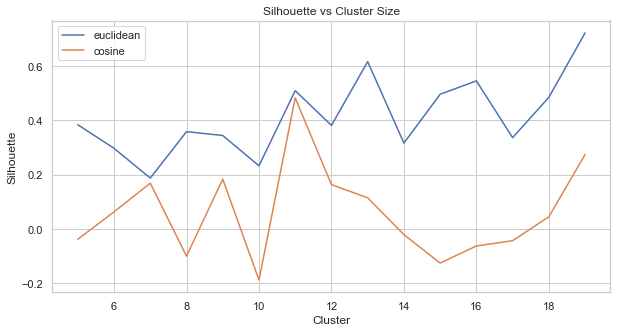

Wall time: 51min 11s


In [43]:
%%time
X1 = df[['admission_source_id','payer_code']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
               'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
               'payer_WC'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7729360557664924
Homogeneity:  0.0024770955818110576
Completeness:  0.0015480660049871841
V-measure:  0.0019053682087609867
Adjusted Rand Index:  -0.0029590866874920465
Adjusted Mutual Information:  0.0018510459629018576
Silhouette Coefficient - Euclidean:  0.16271625720094027
Silhouette Coefficient - Cosine:  0.035205627529058967
Clusters 6 AUC Score Micro= 0.7729630261800873
Homogeneity:  0.0027183488194803796
Completeness:  0.0016027294763263237
V-measure:  0.0020165234146051043
Adjusted Rand Index:  -0.0020105885447466248
Adjusted Mutual Information:  0.0019510360687725518
Silhouette Coefficient - Euclidean:  0.1794354296648501
Silhouette Coefficient - Cosine:  -0.05659216951193773
Clusters 7 AUC Score Micro= 0.7730796234255009
Homogeneity:  0.003031395893854159
Completeness:  0.0017096511488194992
V-measure:  0.0021862805518722685
Adjusted Rand Index:  -0.002781007669895521
Adjusted Mutual Information:  0.0021098328856357686
Silhouette Coefficient - E

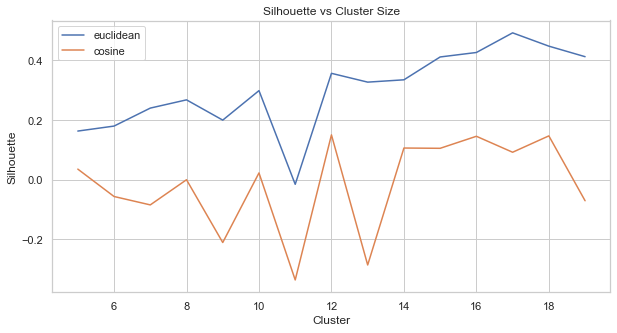

Wall time: 51min 32s


In [35]:
%%time
X1 = df[['admission_type_id','payer_code']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_type_1','admission_type_2','admission_type_3','admission_type_4',
                'admission_type_5','admission_type_6','admission_type_7',
                'payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN',
                'payer_WC'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7746358544289383
Homogeneity:  0.0015070214598440466
Completeness:  0.0011448406252731887
V-measure:  0.001301198429639827
Adjusted Rand Index:  -0.0037535088382280746
Adjusted Mutual Information:  0.0012401766991869505
Silhouette Coefficient - Euclidean:  0.2866049934383883
Silhouette Coefficient - Cosine:  0.14325917646173295
Clusters 6 AUC Score Micro= 0.7743858393161076
Homogeneity:  0.0035311236396985924
Completeness:  0.0022220049571240953
V-measure:  0.0027276199721875155
Adjusted Rand Index:  -0.0025619410188596247
Adjusted Mutual Information:  0.002659479595558419
Silhouette Coefficient - Euclidean:  0.07342721693153184
Silhouette Coefficient - Cosine:  -0.022594583445439163
Clusters 7 AUC Score Micro= 0.7737656634893091
Homogeneity:  0.0026604397518748125
Completeness:  0.0015593244331444775
V-measure:  0.001966218265340466
Adjusted Rand Index:  -0.0031845768072264182
Adjusted Mutual Information:  0.001887899529828875
Silhouette Coefficient - Euc

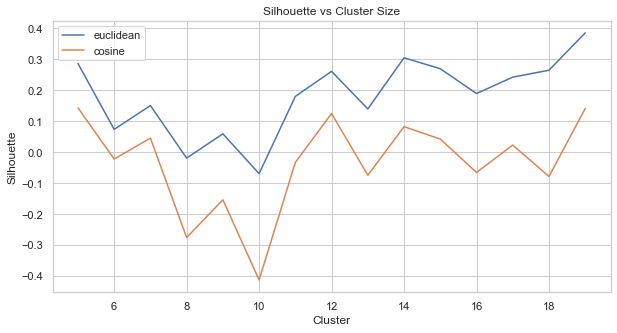

Wall time: 50min 2s


In [36]:
%%time
X1 = df[['admission_source_id','payer_code','admission_type_id']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','admission_source_2','admission_source_3','admission_source_4',
               'admission_source_5','admission_source_6','admission_source_7','admission_source_8','admission_source_9',
               'admission_source_10','admission_source_11','admission_source_13','admission_source_14',
               'admission_source_17','admission_source_22','admission_source_25',
               'payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
               'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN','payer_WC',
                'admission_type_1','admission_type_2','admission_type_3','admission_type_4',
                'admission_type_5','admission_type_6','admission_type_7'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7616962127105488
Homogeneity:  0.002005598405683109
Completeness:  0.0012316203611369835
V-measure:  0.0015260852050042908
Adjusted Rand Index:  0.005203075011891395
Adjusted Mutual Information:  0.0014723286200464404
Silhouette Coefficient - Euclidean:  0.2093357800154266
Silhouette Coefficient - Cosine:  -0.21213888906348274
Clusters 6 AUC Score Micro= 0.7616571228755273
Homogeneity:  0.0023901111699783546
Completeness:  0.0013367947352146347
V-measure:  0.0017146062229007658
Adjusted Rand Index:  0.0004926979808083474
Adjusted Mutual Information:  0.0016512647887610217
Silhouette Coefficient - Euclidean:  0.17030469671046103
Silhouette Coefficient - Cosine:  -0.27554962339821637
Clusters 7 AUC Score Micro= 0.7614888405453473
Homogeneity:  0.0026381454841724467
Completeness:  0.0013061171931987533
V-measure:  0.0017472097864099736
Adjusted Rand Index:  0.0015833544172775135
Adjusted Mutual Information:  0.0016770385536953585
Silhouette Coefficient - Eucl

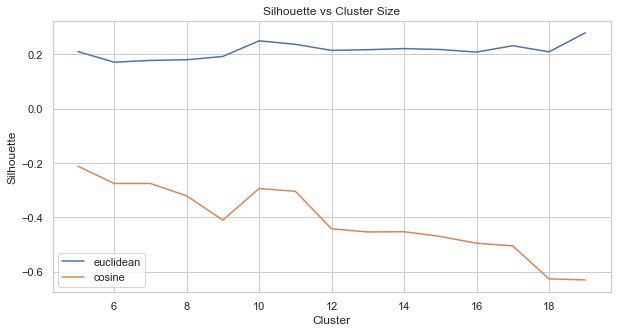

Wall time: 1h 5min 32s


In [37]:
%%time
X1 = df[['discharge_disposition_id','time_in_hospital']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6',
                'discharge_7','discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15',
                'discharge_16','discharge_17','discharge_18','discharge_19','discharge_20','discharge_22',
                'discharge_23','discharge_24','discharge_25','discharge_27','discharge_28',
                'time_in_hospital'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7623806478856057
Homogeneity:  0.002252299723659043
Completeness:  0.002451386602501491
V-measure:  0.0023476299160035234
Adjusted Rand Index:  0.0007368551049974985
Adjusted Mutual Information:  0.0022732757471847042
Silhouette Coefficient - Euclidean:  0.06905002967112246
Silhouette Coefficient - Cosine:  0.31604088103589667
Clusters 6 AUC Score Micro= 0.7637371376053925
Homogeneity:  0.004987400860727888
Completeness:  0.003607526398387765
V-measure:  0.004186697507029038
Adjusted Rand Index:  0.004628274807084982
Adjusted Mutual Information:  0.0041121963432372306
Silhouette Coefficient - Euclidean:  0.5315708382832263
Silhouette Coefficient - Cosine:  0.3073929395864401
Clusters 7 AUC Score Micro= 0.767144010024886
Homogeneity:  0.01339129709235038
Completeness:  0.010155618461816557
V-measure:  0.011551143814645181
Adjusted Rand Index:  0.0052495722940992156
Adjusted Mutual Information:  0.011459993793319547
Silhouette Coefficient - Euclidean:  0.394

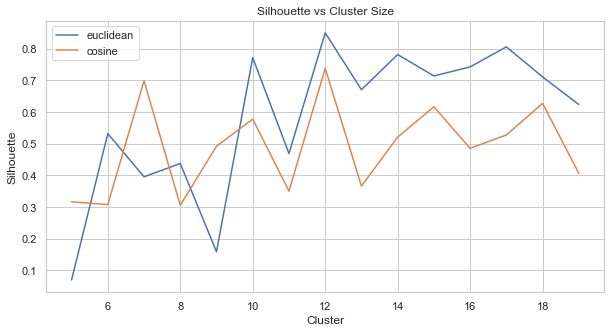

Wall time: 49min 35s


In [38]:
%%time
X1 = df[['discharge_disposition_id','race']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','admission_source_1','discharge_1','discharge_2','discharge_3','discharge_4','discharge_5',
                'discharge_6','discharge_7','discharge_8','discharge_9','discharge_11','discharge_13','discharge_14',
                'discharge_15','discharge_16','discharge_17','discharge_18','discharge_19','discharge_20',
                'discharge_22','discharge_23','discharge_24','discharge_25','discharge_27','discharge_28',
                'race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other'],
               axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:
    
    kp = KModes(n_clusters=i, init='Huang', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1)
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7616679699703648
Homogeneity:  0.00890484631714561
Completeness:  0.006192886509667906
V-measure:  0.007305295869347568
Adjusted Rand Index:  -0.0035968115234675333
Adjusted Mutual Information:  0.007247670690132044
Silhouette Coefficient - Euclidean:  0.1717828619738056
Silhouette Coefficient - Cosine:  -0.2993155933513264
Clusters 6 AUC Score Micro= 0.761617399395562
Homogeneity:  0.009197840541794263
Completeness:  0.005644638743772782
V-measure:  0.006995931890131309
Adjusted Rand Index:  -0.002469148399201597
Adjusted Mutual Information:  0.006929124597891742
Silhouette Coefficient - Euclidean:  0.11189675272135177
Silhouette Coefficient - Cosine:  -0.3878171447635762
Clusters 7 AUC Score Micro= 0.7627766934642347
Homogeneity:  0.009773307930869486
Completeness:  0.006066785430263954
V-measure:  0.007486390491354965
Adjusted Rand Index:  0.0003926975507319802
Adjusted Mutual Information:  0.0074054869021683315
Silhouette Coefficient - Euclidean:  0.35

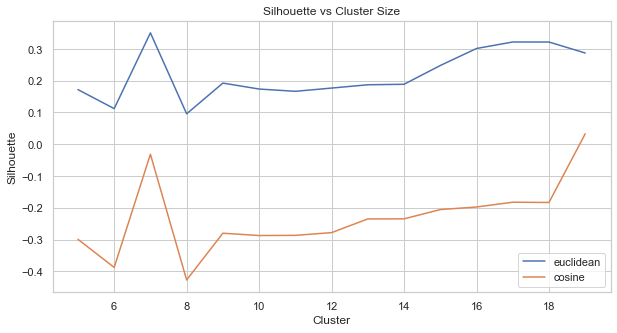

Wall time: 58min 53s


In [39]:
%%time
X1 = df[['discharge_disposition_id','number_diagnoses']]

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','discharge_1','discharge_2','discharge_3','discharge_4','discharge_5','discharge_6',
                'discharge_7','discharge_8','discharge_9','discharge_11','discharge_13','discharge_14','discharge_15',
                'discharge_16','discharge_17','discharge_18','discharge_19','discharge_20','discharge_22',
                'discharge_23','discharge_24','discharge_25','discharge_27','discharge_28',
                'number_diagnoses'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7722932832012146
Homogeneity:  0.004265617371314091
Completeness:  0.002696102937363056
V-measure:  0.003303937249571036
Adjusted Rand Index:  0.0018407463020663646
Adjusted Mutual Information:  0.003249312397041337
Silhouette Coefficient - Euclidean:  0.3194917160535232
Silhouette Coefficient - Cosine:  -0.16452196508761413
Clusters 6 AUC Score Micro= 0.7721553391585739
Homogeneity:  0.004567303436265832
Completeness:  0.0025788266172244497
V-measure:  0.0032964089884231318
Adjusted Rand Index:  0.0007076285536665179
Adjusted Mutual Information:  0.0032327793471076615
Silhouette Coefficient - Euclidean:  0.2902652077400051
Silhouette Coefficient - Cosine:  -0.19896054329639332
Clusters 7 AUC Score Micro= 0.7724254869439185
Homogeneity:  0.004778747666730386
Completeness:  0.0024653749980038174
V-measure:  0.003252679603751146
Adjusted Rand Index:  0.0009379160332392746
Adjusted Mutual Information:  0.0031806626381384786
Silhouette Coefficient - Euclidean:

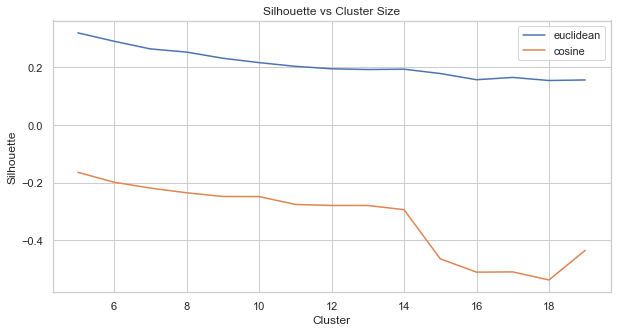

Wall time: 1h 16min 34s


In [40]:
%%time
X1 = df[['payer_code','num_medications']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','payer_BC','payer_CH','payer_CM','payer_CP','payer_DM','payer_HM','payer_MC',
                'payer_MD','payer_MP','payer_OG','payer_OT','payer_PO','payer_SI','payer_SP','payer_UN','payer_WC',
                'num_medications'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7723930340814872
Homogeneity:  0.0031504403604072236
Completeness:  0.002635621560921661
V-measure:  0.0028701277840386652
Adjusted Rand Index:  -0.010616374687275228
Adjusted Mutual Information:  0.0028058439804262733
Silhouette Coefficient - Euclidean:  -0.11342903115605256
Silhouette Coefficient - Cosine:  -0.5004139787087902
Clusters 6 AUC Score Micro= 0.7722436070605313
Homogeneity:  0.0036345756088409322
Completeness:  0.0027375672339004387
V-measure:  0.003122935358309109
Adjusted Rand Index:  -0.011545898496466835
Adjusted Mutual Information:  0.0030471626714874463
Silhouette Coefficient - Euclidean:  -0.06089247710266093
Silhouette Coefficient - Cosine:  -0.4599215305051002
Clusters 7 AUC Score Micro= 0.7723349883431339
Homogeneity:  0.0043420235387427305
Completeness:  0.0026592886250719643
V-measure:  0.0032984370747102913
Adjusted Rand Index:  -0.006814588505757642
Adjusted Mutual Information:  0.0032180595121732653
Silhouette Coefficient - Euc

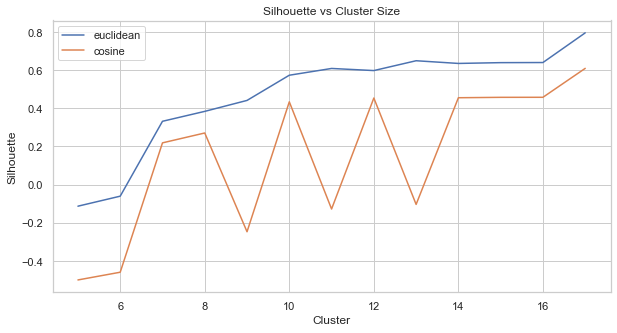

Wall time: 1h 10min 33s


In [44]:
%%time
X1 = df[['payer_code','med_diabetes']]
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other',
                'med_diabetes'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,18)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

Clusters 5 AUC Score Micro= 0.7723930340814872
Homogeneity:  0.0031504403604072236
Completeness:  0.002635621560921661
V-measure:  0.0028701277840386652
Adjusted Rand Index:  -0.010616374687275228
Adjusted Mutual Information:  0.0028058439804262733
Silhouette Coefficient - Euclidean:  -0.13294046243700677
Silhouette Coefficient - Cosine:  -0.30582385305097026
Clusters 6 AUC Score Micro= 0.7722436070605313
Homogeneity:  0.0036345756088409322
Completeness:  0.0027375672339004387
V-measure:  0.003122935358309109
Adjusted Rand Index:  -0.011545898496466835
Adjusted Mutual Information:  0.0030471626714874463
Silhouette Coefficient - Euclidean:  -0.09701643855108519
Silhouette Coefficient - Cosine:  -0.2706230898995994
Clusters 7 AUC Score Micro= 0.7723349883431339
Homogeneity:  0.0043420235387427305
Completeness:  0.0026592886250719643
V-measure:  0.0032984370747102913
Adjusted Rand Index:  -0.006814588505757642
Adjusted Mutual Information:  0.0032180595121732653
Silhouette Coefficient - Eu

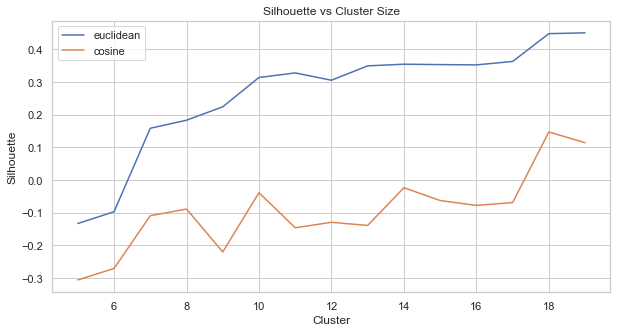

Wall time: 51min 26s


In [43]:
%%time
X1 = df[['race','payer_code','med_diabetes']]
cleanup_race = {"race": {"AfricanAmerican": 0, "Asian": 1, "Caucasian": 2, "Hispanic": 3, "Other": 4}}
X1.replace(cleanup_race,inplace=True)
cleanup_pc = {"payer_code": {"BC": 0, "CH": 1, "CM": 2, "CP": 3, "DM": 4, "HM": 5, "MC": 6, "MD": 7, "MP":8, "OG": 9,
                         "OT": 10, "PO": 11, "SI": 12, "SP": 13, "UN": 14, "WC": 15}}
X1.replace(cleanup_pc,inplace=True)

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','race_AfricanAmerican','race_Asian','race_Caucasian','race_Hispanic','race_Other',
                'med_diabetes'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    kp = KPrototypes(n_clusters=i, init='Cao', n_init=3, verbose=False, random_state=1)
    kp.fit_predict(X1, categorical=[0,1])
    newfeature = kp.labels_ 

    X2 = np.column_stack((X,pd.get_dummies(newfeature)))

    lgb_model(X2,y)
    cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
silhouette_plot(k,seuclid,scosine)

In [69]:
%%time
X1 = df[['med_change','med_diabetes']].to_numpy()

df_kmodes = df_imputed.copy()
df_kmodes.drop(['readmitted','med_change','med_diabetes'], axis=1, inplace=True)
X = df_kmodes.values
scl = StandardScaler()
X = scl.fit_transform(X)

seuclid = []
scosine = []
k = range(5,20)
for i in k:

    cls = AgglomerativeClustering(n_clusters=n, linkage='ward')
    cls.fit(X1) 
    #newfeature = cls.labels_ 
    #X2 = np.column_stack((X,pd.get_dummies(newfeature)))
    
    #lgb_model(X2,y)
    #cluster_metrics(y_lb, yhat_score, X1, newfeature)
    
#silhouette_plot(k,seuclid,scosine)

MemoryError: Unable to allocate array with shape (1786854090,) and data type float64

<a id = 'Section_6'></a>

## 6. Modeling and Evaluation 2
*(10 points)* 

*Evaluate and Compare. Use internal and/or external validation measures to describe and compare the clusterings and the clusters.*

<a id = 'Section_7'></a>

## 7.  Modeling and Evaluation 3
*(10 points)* 

*Visualize Results*

<a id = 'Section_8'></a>

## 8. Modeling and Evaluation 4
*(20 points)* 

*Summarize the ramifications. Describe your results. What findings are the most interesting and why?*

<a id = 'Section_5'></a>

## 9. Deployment

*(10 points)*

*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
* *How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?*
* *How would your deploy your model for interested parties?*
* *What other data should be collected?*
* *How often would the model need to be updated, etc.?*

<a id = 'Section_6'></a>

## 10. Exceptional Work

*(10 points)*

*You have free reign to provide additional analyses or combine analyses.*